
# Individual Assignment I: Machine Learning Foundation
**Data Preparation**

GitHub Repository: [https://github.com/christophrrrrr/ML-fundamentals-2026](https://github.com/christophrrrrr/ML-fundamentals-2026)


This notebook executes data preparation and feature engineering tasks for the UCI Bank Marketing Dataset (`bank-additional.csv`), adhering to data leakage prevention principles.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    ConfusionMatrixDisplay, classification_report, f1_score,
    precision_recall_curve, average_precision_score
)
from sklearn.feature_selection import VarianceThreshold

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import RandomOverSampler


## 1. Identifying the Prediction Target

*Lecture material: Lecture 1 (Problem Formulation), Lecture 2 (Data Inspection).*

**Target Selection:**
The target variable is `y`. `y` records `"yes"` or `"no"` indicating whether the client subscribed to a term deposit. This aligns with the stated objective of the direct marketing campaigns.

**Invalid Alternatives:**
Three other variables might superficially appear to be valid prediction targets but must not be used:
1. `duration`: One might consider predicting call duration as a proxy for engagement. However, `duration` is only known after the call ends — it is unavailable at the moment the prediction needs to be made (i.e., *before* the call is placed). More critically, using it as a feature — not just as a target — would introduce target leakage, since call duration is strongly determined by whether the client ultimately subscribes. For both reasons it is dropped entirely from the dataset before any further processing.
2. `poutcome`: Records the result of the previous marketing campaign. The prediction objective defined for this assignment is whether the client subscribes in the *current* campaign. `poutcome` describes an event that has already occurred and is available as an input at prediction time — it is an input feature, not the target. Using it as a prediction target would mean predicting something already known, which has no operational value.
3. `campaign`: Records the number of contacts performed during the current campaign. One might argue this represents campaign effort worth predicting or optimizing. However, `campaign` is a campaign execution variable accumulated during the contact process — it is not the business outcome. The goal is predicting client behavior (`y`), not the number of calls made. It is also partially available at prediction time (current call count), making its use as a target conceptually incoherent.



## 2. Data Loading and Exploration

*Lecture material: Lecture 1 (Problem Formulation), Lecture 2 (Data Inspection and EDA).*

- `bank-additional.csv` is the 10% sample (4119 rows) randomly selected from `bank-additional-full.csv` (41188 rows).
- We prefer the full dataset but fall back to the 10% sample to keep computation light or if the full set is unavailable. The preprocessing pipeline remains structurally identical regardless.
Note that UCI bank datasets commonly use the semicolon `;` separator.


In [2]:

# Load dataset
import os

full_filepath = 'data/bank-additional-full.csv'
sample_filepath = 'data/bank-additional.csv'
github_sample_url = 'https://raw.githubusercontent.com/christophrrrrr/ML-fundamentals-2026/main/data/bank-additional.csv'

# Attempt to load full dataset first, then fall back to sample, then to remote link
if os.path.exists(full_filepath):
    print(f"Loading full dataset from: {full_filepath}")
    df = pd.read_csv(full_filepath, sep=';')
elif os.path.exists(sample_filepath):
    print(f"Loading 10% sample dataset from: {sample_filepath}")
    df = pd.read_csv(sample_filepath, sep=';')
else:
    print(f"Local instance not found. Downloading 10% sample directly from GitHub repository...")
    df = pd.read_csv(github_sample_url, sep=';')

# Basic structure
print(f"Number of observations: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")

print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Summary Statistics ---")
display(df.describe())


Local instance not found. Downloading 10% sample directly from GitHub repository...
Number of observations: 4119
Number of features: 21

--- Data Types ---
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

--- Summary Statistics ---


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


**Variable Identification (raw dataset, prior to feature engineering):**
- **Numerical:** `age`, `duration`, `campaign`, `pdays`, `previous`,
  `emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`,
  `nr.employed`
- **Categorical:** `job`, `marital`, `education`, `default`, `housing`,
  `loan`, `contact`, `month`, `day_of_week`, `poutcome`, `y`

Note: `duration` is identified here for completeness but is dropped immediately
due to target leakage. `pdays` is decomposed into a single binary feature
(`prev_contacted`) that captures all the usable information: whether the client
was previously contacted. The raw `pdays` magnitude is discarded because 96% of
its values are the sentinel 999, meaning median imputation would reduce it to a
near-constant column that adds noise without signal.


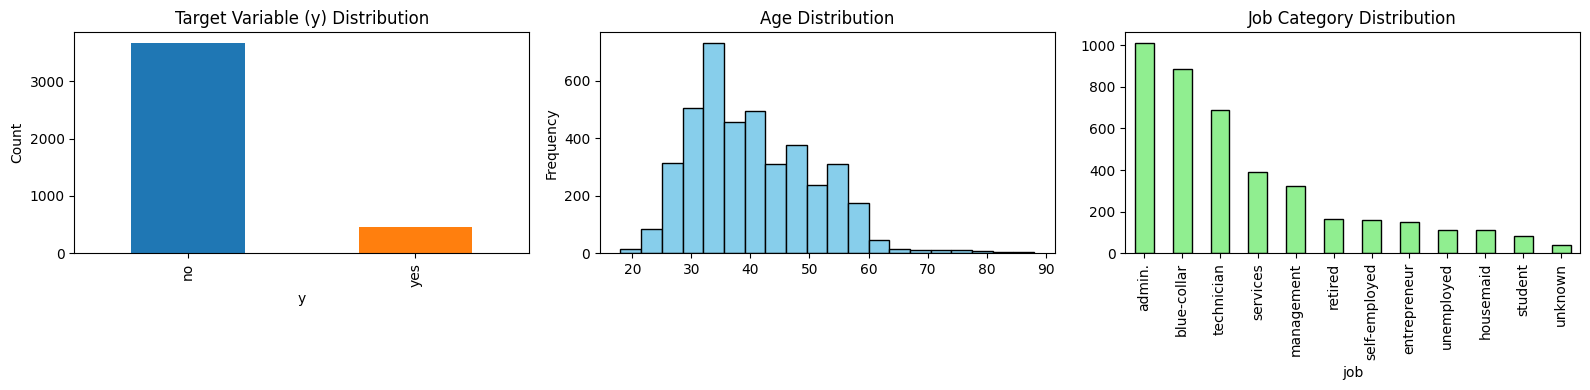

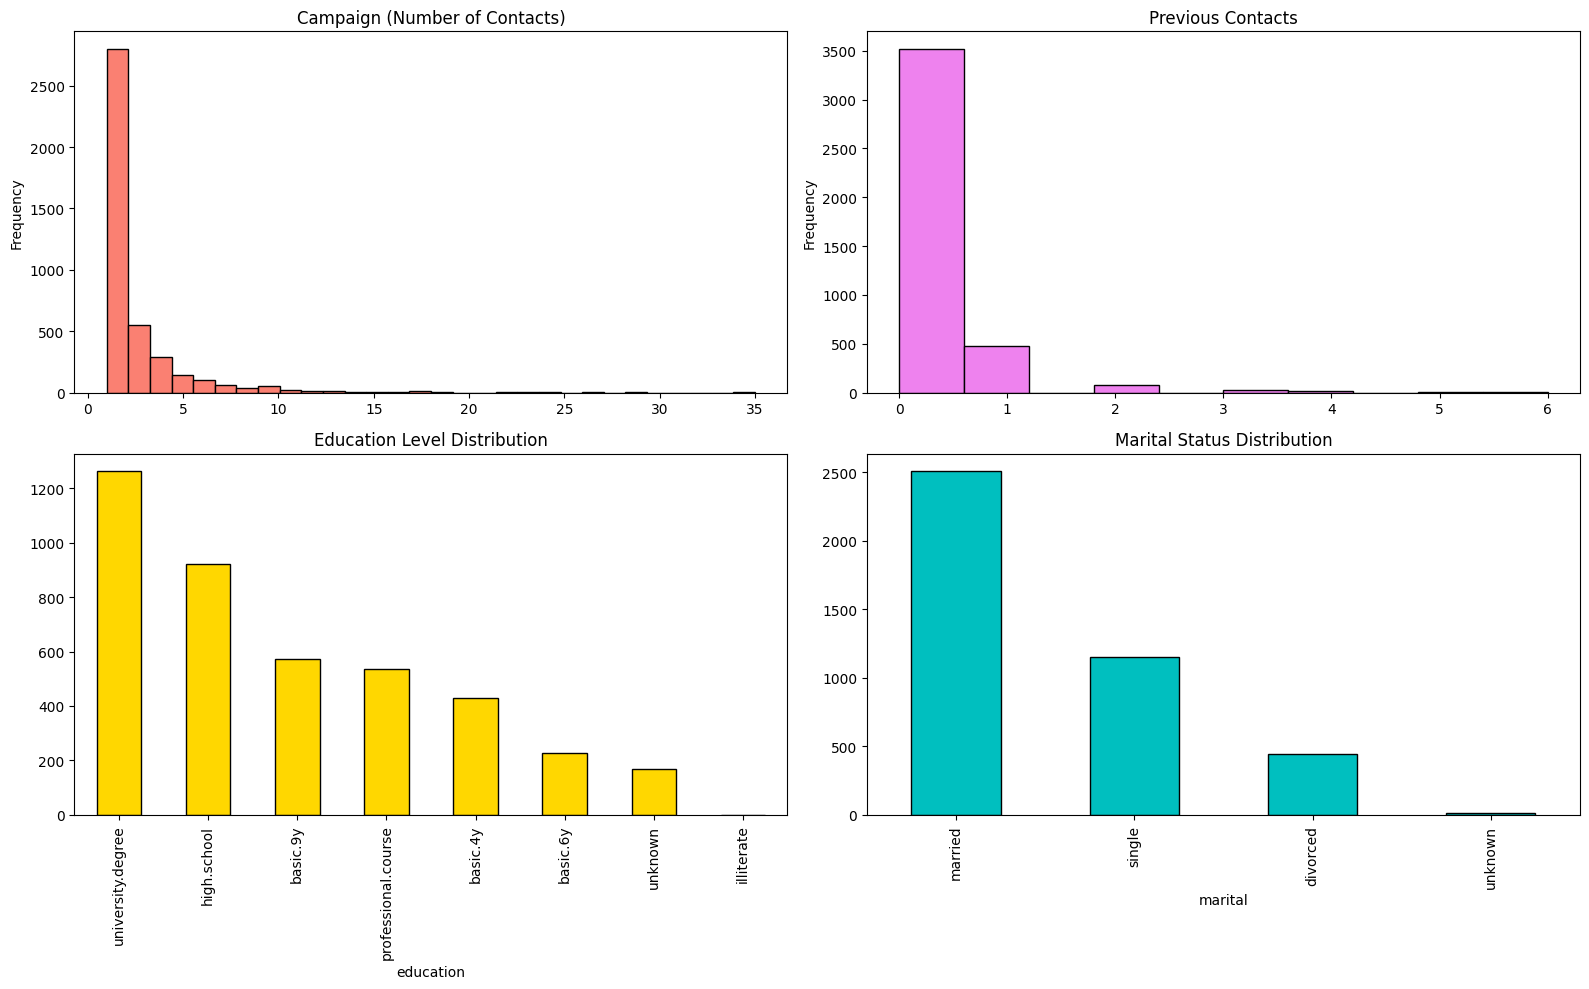

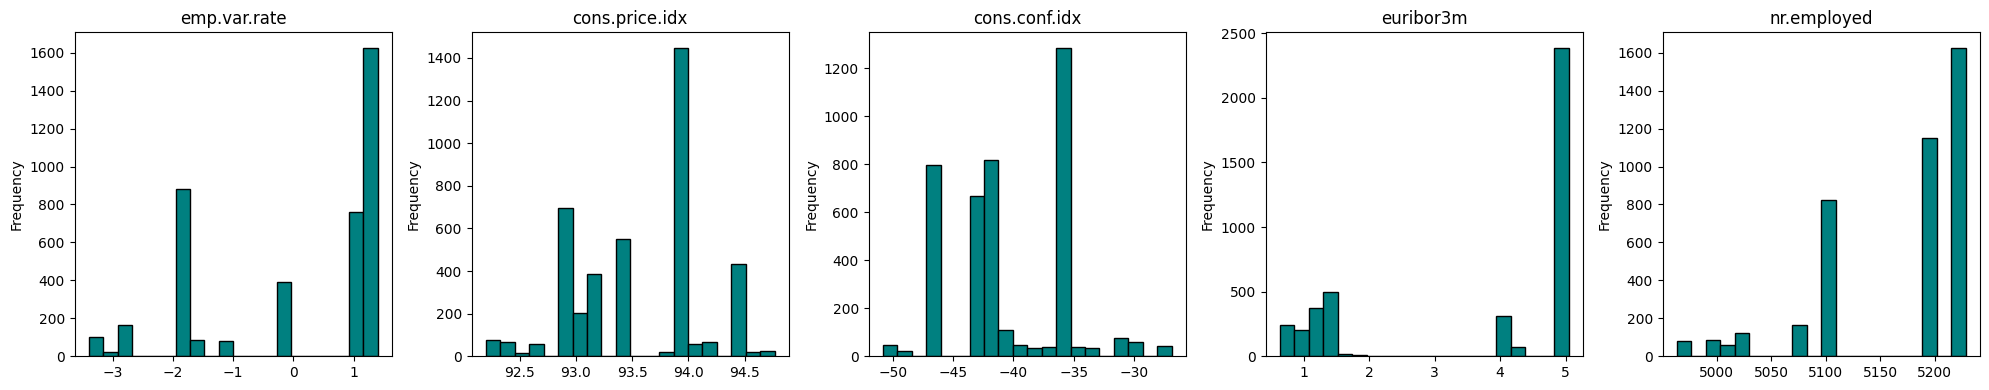

Target variable counts:
y
no     3668
yes     451
Name: count, dtype: int64

Target variable percentages:
y
no     0.890507
yes    0.109493
Name: proportion, dtype: float64


In [3]:

# Target Distribution
y_counts = df['y'].value_counts()
y_pct = df['y'].value_counts(normalize=True)

# --- Figure 1: Target, Age, Job ---
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
df['y'].value_counts().plot(kind='bar', color=['#1f77b4', '#ff7f0e'], ax=axes[0])
axes[0].set_title('Target Variable (y) Distribution')
axes[0].set_ylabel('Count')

df['age'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black', ax=axes[1])
axes[1].set_title('Age Distribution')

df['job'].value_counts().plot(kind='bar', color='lightgreen', edgecolor='black', ax=axes[2])
axes[2].set_title('Job Category Distribution')
plt.tight_layout()
plt.show()

# --- Figure 2: Campaign, Previous, Education, Marital ---
fig2, axes2 = plt.subplots(2, 2, figsize=(16, 10))

df['campaign'].plot(kind='hist', bins=30, color='salmon', edgecolor='black', ax=axes2[0, 0])
axes2[0, 0].set_title('Campaign (Number of Contacts)')

df['previous'].plot(kind='hist', bins=10, color='violet', edgecolor='black', ax=axes2[0, 1])
axes2[0, 1].set_title('Previous Contacts')

df['education'].value_counts().plot(kind='bar', color='gold', edgecolor='black', ax=axes2[1, 0])
axes2[1, 0].set_title('Education Level Distribution')

df['marital'].value_counts().plot(kind='bar', color='c', edgecolor='black', ax=axes2[1, 1])
axes2[1, 1].set_title('Marital Status Distribution')

plt.tight_layout()
plt.show()

# --- Figure 3: Macroeconomic Variables ---
macro_vars = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
fig3, axes3 = plt.subplots(1, 5, figsize=(20, 4))
for i, var in enumerate(macro_vars):
    df[var].plot(kind='hist', bins=20, color='teal', edgecolor='black', ax=axes3[i])
    axes3[i].set_title(var)
plt.tight_layout()
plt.show()

print("Target variable counts:")
print(y_counts)
print("\nTarget variable percentages:")
print(y_pct)



**General Observations:**
- **Class Imbalance:** Only ~10.9% of clients subscribed (`yes`). Class imbalance handling is required to prevent the model from trivializing predictions.
- **Skewed Variables:** `campaign` is right-skewed (most clients are contacted 1–3 times, with a long tail reaching 35). `previous` is zero for the majority of clients. A log transform of `campaign` was considered to reduce the influence of outliers on the linear model's coefficient estimation. It was ultimately not applied here to keep the pipeline interpretable and because StandardScaler will centre and scale the variable regardless — but this remains a worthwhile preprocessing step to explore.
- **Category Ratios:** `university.degree` and `high.school` represent the most frequent `education` levels. The majority of clients are married.
- **Target Leakage Variable:** `duration` is only known after the call finishes. It must be dropped.
- **Implicit Missing Values:** Categorical variables utilize `"unknown"` as an implicit missing value. `pdays` uses `999` to indicate "never contacted before".



**Macroeconomic Observations:**
- `euribor3m` and `nr.employed` show bimodal distributions, clustering into two distinct regimes that likely correspond to pre- and post-2008 economic periods in the dataset.
- `emp.var.rate` is similarly clustered rather than continuous, reinforcing that macroeconomic features track the same underlying economic cycle.
- These distributions suggest the macroeconomic block may carry redundant information — addressed formally in Feature Selection.



## 3. Task Ordering

*Lecture material: Lecture 2 (Data Splitting and Leakage), Lecture 5 (Preprocessing), Lecture 9 (ML Pipeline).*

To prevent data leakage, data preparation tasks are executed in the following sequence:

1. **Identifying Target & Data Loading** (Completed above)
    - Allowed: Raw dataset viewing, broad target assessment.
    - Not allowed: Predicting on or analyzing combinations of target vs features globally.
    - Leakage risk if changed: None at this stage, assuming `duration` is dropped manually before modeling metrics run.
2. **Managing Missing Values (Identification & Structural Cleaning)**
    - Allowed: Finding distinct string literals (e.g. `"unknown"`) or sentinel values (`999`) and structurally replacing them with `NaN` or indicator flags.
    - Not allowed: Computing median, mean, or mode across the column to fill the `NaN` values.
    - Leakage risk if changed: Replacing `"unknown"` specifically does not use global distribution data. However, if statistical imputation were performed here instead, it would leak test-set central tendencies into the training data.
3. **Data Splitting**
    - Allowed: Raw input variables (`X`) and targets (`y`).
    - Not allowed: Any fitted statistical boundaries, encodings, or synthetic samples.
    - Leakage risk if changed: If delayed, transformation steps would consume information belonging to the test set, compromising final evaluation integrity.
4. **Managing Missing Values (Statistical Imputation)**
    - Allowed: Medians/Modes calculated from `X_train`.
    - Not allowed: Test set distribution properties.
    - Leakage risk if changed: If placed before Data Splitting, computed statistics would include test observations. Note: `pdays_clean` was dropped rather than imputed precisely because 96% missingness would make any imputed statistic meaningless — a principled choice over mechanical imputation.
5. **Encoding Categorical Variables**
    - Allowed: List of distinct categories present in `X_train`.
    - Not allowed: Categories that only exist in `X_test`.
    - Leakage risk if changed: The algorithm would map dummy dimensions for categories it has not seen yet.
6. **Feature Scaling**
    - Allowed: Compute mean and variance only over `X_train` via `.fit()`.
    - Not allowed: Running `.fit()` on `X_test`.
    - Leakage risk if changed: If placed before Data Splitting, the feature distances for the test set observations would be compressed based on training outliers.
7. **Feature Selection**
    - Allowed: Variance thresholds and correlation matrices computed over `X_train`.
    - Not allowed: Entire dataset correlations.
    - Leakage risk if changed: If executed upfront, variables would be deleted based on how they correlate with target labels inside the test set.
8. **Addressing Class Imbalance**
    - Allowed: Resampling methods (e.g. RandomOverSampler) applied within the training set.
    - Not allowed: Resampling before Data Splitting.
    - Leakage risk if changed: If RandomOverSampler generated synthetic samples before the train/test split, synthesized points mathematically linked to train observations would land in the test set.

**Incorrect Ordering Example (Scaling before Splitting):**
If Feature Scaling is performed before Data Splitting, the mean and standard deviation are calculated across the entire dataset. The standardized test values inherently contain information about the central tendency of the training set. This is data leakage.

**Incorrect Ordering Example 2 — Resampling before splitting:**
If RandomOverSampler were applied to the full dataset before the train/val/test split,
synthetic minority samples would be generated using the entire data
distribution. When the dataset is subsequently split, some synthetic
samples — constructed using observations that end up in the validation or
test sets — will appear in the training set. The model trains on data
derived from the test set. Validation and test metrics will be inflated
because the boundary between training and evaluation data has been
contaminated. The correct position for any resampling operation is after
splitting, applied to the training set only.



## 4. Managing Missing Values (Part 1: Identification & Sentinel Cleaning)

*Lecture material: Lecture 2 (Data Inspection), Lecture 5 (Preprocessing and Pipeline Discipline).*

**Identification:**
- Explicit missing values (`NaN`) are largely absent in this CSV.
- Implicit missing values are abundant. Words like `"unknown"` map strictly to missing information.
- In numerical columns, `pdays=999` acts as a sentinel for "client was not previously contacted".

We must convert these implicit symbols into standard structural missingness (`NaN`) before splitting, alongside creating feature flags.

*Note on Leakage:* Because we are just structurally replacing `"unknown" -> NaN` and extracting `pdays != 999`, we are not calculating statistics. Therefore, this is purely "data cleaning" and is safe to execute before Data Splitting.


In [4]:

# Drop 'duration' immediately to prevent leakage before any further inspection
if 'duration' in df.columns:
    df = df.drop(columns=['duration'])

# Count categorical 'unknown' and numerical '999' before cleaning
missing_counts = []

for col in df.drop(columns=['y']).select_dtypes(include=['object']).columns:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        missing_counts.append({
            'Variable': col,
            'Implicit Missing': unknown_count,
            '% of Total': f"{(unknown_count / len(df)) * 100:.2f}%"
        })

pdays_count = (df['pdays'] == 999).sum()
if pdays_count > 0:
    missing_counts.append({
        'Variable': 'pdays',
        'Implicit Missing': pdays_count,
        '% of Total': f"{(pdays_count / len(df)) * 100:.2f}%"
    })

missing_df = pd.DataFrame(missing_counts)
print("--- Implicit Missing Values Summary Before Structural Cleaning ---")
display(missing_df)


--- Implicit Missing Values Summary Before Structural Cleaning ---


,Variable,Implicit Missing,% of Total
0,job,39,0.95%
1,marital,11,0.27%
2,education,167,4.05%
3,default,803,19.50%
4,housing,105,2.55%
5,loan,105,2.55%
6,pdays,3959,96.12%


In [5]:
# 1. Handle Categorical 'unknown'
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].replace('unknown', np.nan)

# 2. Handle 'pdays' Sentinel
# 96% of pdays values are 999 (sentinel for 'never contacted').
# We extract only the binary signal — was this client previously contacted?
# The raw magnitude (pdays_clean) is NOT retained: with 96% missing,
# median imputation would produce a near-constant column carrying no
# meaningful additional signal beyond what prev_contacted already encodes.
df['prev_contacted'] = (df['pdays'] != 999).astype(int)
df = df.drop(columns=['pdays'])

missing_summary = df.isna().sum()
print("Missing (NaN) counts after structured cleaning:")
print(missing_summary[missing_summary > 0])
print(f"\npdays replaced by binary feature 'prev_contacted' (1 = was previously contacted, 0 = never contacted).")
print(f"prev_contacted=1: {(df['prev_contacted']==1).sum()} rows ({(df['prev_contacted']==1).mean():.1%})")
print(f"prev_contacted=0: {(df['prev_contacted']==0).sum()} rows ({(df['prev_contacted']==0).mean():.1%})")


Missing (NaN) counts after structured cleaning:
job           39
marital       11
education    167
default      803
housing      105
loan         105
dtype: int64

pdays replaced by binary feature 'prev_contacted' (1 = was previously contacted, 0 = never contacted).
prev_contacted=1: 160 rows (3.9%)
prev_contacted=0: 3959 rows (96.1%)



## 5. Data Splitting

*Lecture material: Lecture 2 (Data Splitting and Leakage), Lecture 9 (ML Pipeline).*

The independent features `X` and the target `y` are separated using a stratified split.

**Proportions:**
- Training: 70% (Used to learn parameters for imputation, scaling, encoding, and modeling).
- Validation: 15% (Used to evaluate model health during iterations and tune hyperparameters).
- Test: 15% (Held-out subset for final generalization reporting).

**Stratification:** `stratify=y` is used because the target is imbalanced (~11% positives). A random split could yield a training set with very few positive examples, leading to instability.

**Leakage Prevention:** Executing this split here ensures that upcoming steps (Scaling, Imputation, Encoding) can only `fit()` on mathematical properties present in `X_train`.


In [6]:

X = df.drop(columns=['y'])
y = df['y']

# First split: Train (70%), Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# Second split: Temp -> Validation (50% of 30% = 15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (2883, 19)
X_val shape: (618, 19)
X_test shape: (618, 19)


## 6. Managing Missing Values (Part 2: Imputation)

The statistical imputation logic is established inside `scikit-learn` Pipelines,
fitted exclusively on `X_train`.

- **Numerical Imputation:** The only numerical column with missing values is `pdays_clean`,
  which has been dropped entirely (see Section 4). All remaining numerical features are
  complete. Median imputation is specified in the numerical pipeline as a defensive measure
  in case any edge-case `NaN` values arise in a different dataset instance, but it is not
  expected to activate on this data.
- **Categorical Imputation:** Categorical `NaN` values (converted from `"unknown"` in
  Section 4) are replaced with the explicit string `"missing"`. This treats missingness
  as its own category rather than discarding it, allowing the model to learn whether
  the absence of information is itself predictive of subscription behaviour.
- **Note on `default` (19.5% missing):** `default` has the highest missingness rate of
  any categorical variable. Dropping the column was considered but rejected: the 80.5%
  of non-missing values still carry signal, and encoding missingness as `"missing"` lets
  the model learn from the pattern of omission itself — for instance, banks may
  systematically withhold default status for certain client profiles.


In [7]:

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

# Define Imputers
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')

# We hold off assembling the full ColumnTransformer until we define Scaling/Encoding.



## 7. Encoding Categorical Variables

*Lecture material: Lecture 4 (Categorical Encoding), Lecture 6 (Linear Models).*

**Classification:**
- **Nominal Variables** (e.g., `job`, `marital`, `contact`, `month`): No intrinsic mathematical order.
- **Ordinal Variables** (e.g., `education`): Intrinsic order (`basic.4y` < `high.school` < `university.degree`).

**Strategy — Education (Ordinal vs One-Hot):**
`education` is a genuine ordinal variable. OrdinalEncoder would assign integer ranks `[0, 1, 2, ... 7]`, which assumes uniform interval spacing between consecutive levels. There is no empirical basis for claiming that the educational jump from `basic.4y` to `basic.6y` carries the same predictive weight as the jump from `high.school` to `university.degree`. Because Logistic Regression relies on linear combinations of its inputs, an incorrectly-spaced ordinal encoding would systematically distort the coefficient for `education`, biasing all predictions that depend on it.

**One-Hot Encoding** is therefore applied to `education` — and all other categorical variables — as a non-parametric alternative. This gives the model a free, independent coefficient for every category, making no assumptions about inter-level distances. The cost is additional dimensionality, but for a dataset of this size (~4000 observations, ~60 post-encoding features) this is well within the capacity of Logistic Regression with L2 regularization.

*Impact on Dimensionality:* Expands categorical columns from 10 variables to ~51 binary features.
*Impact on Interpretability:* The Logistic Regression yields a discrete coefficient for each category (e.g., `job_retired`, `education_university.degree`), making it straightforward to rank which groups are most predictive of subscription.
*Impact on Decision Boundaries:* Allows the linear model to form piecewise subgroup effects — effectively an intercept shift per category — which is the appropriate structure for nominal group membership.

**Data Leakage Check:** `handle_unknown='ignore'` is enforced so that if the Validation set contains a category unseen in Train, it produces an all-zero row rather than crashing or leaking information from the test set.

**Cyclical Variables — `month` and `day_of_week`:**
`month` and `day_of_week` have inherent cyclical structure: December (12) is adjacent to January (1), and Friday is adjacent to Monday. One-hot encoding treats them as unordered nominal categories, which loses this adjacency. The standard solution is to apply a sine/cosine transform:

$$x_{\sin} = \sin\left(\frac{2\pi \cdot k}{K}\right), \quad x_{\cos} = \cos\left(\frac{2\pi \cdot k}{K}\right)$$

where $k$ is the position (e.g. month number) and $K$ is the cycle length (12 for months, 5 for working days). This preserves wrap-around continuity. Both encodings are implemented below and compared — One-Hot is retained in the main pipeline because it is model-agnostic and avoids introducing assumptions about whether calendar position is actually cyclically predictive in this dataset. However, the sin/cos features are constructed and shown for completeness.


Theoretical Ordinal Hierarchy for Education:
['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree', 'missing']

Reason for rejecting OrdinalEncoder: interval spacing between levels is unknown.
Logistic Regression treats these as equal steps — an assumption that does not hold here.


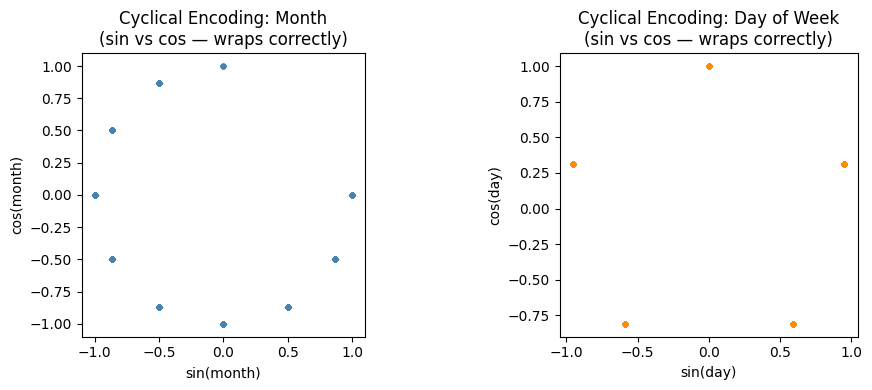

Cyclical features constructed for illustration.
One-Hot Encoding is retained in the main pipeline as the conservative,
model-agnostic choice that makes no assumptions about cyclical predictive structure.


In [8]:

# --- Ordinal hierarchy for education (shown for transparency) ---
education_order = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y',
                   'high.school', 'professional.course', 'university.degree', 'missing']
print(f"Theoretical Ordinal Hierarchy for Education:\n{education_order}")
print("\nReason for rejecting OrdinalEncoder: interval spacing between levels is unknown.")
print("Logistic Regression treats these as equal steps — an assumption that does not hold here.")

# --- Cyclical encoding demo for month and day_of_week ---
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,
             'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
dow_map   = {'mon':1,'tue':2,'wed':3,'thu':4,'fri':5}

df_cycle = X_train[['month','day_of_week']].copy()
df_cycle['month_num'] = df_cycle['month'].map(month_map)
df_cycle['dow_num']   = df_cycle['day_of_week'].map(dow_map)

df_cycle['month_sin'] = np.sin(2 * np.pi * df_cycle['month_num'] / 12)
df_cycle['month_cos'] = np.cos(2 * np.pi * df_cycle['month_num'] / 12)
df_cycle['dow_sin']   = np.sin(2 * np.pi * df_cycle['dow_num'] / 5)
df_cycle['dow_cos']   = np.cos(2 * np.pi * df_cycle['dow_num'] / 5)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(df_cycle['month_sin'], df_cycle['month_cos'],
                alpha=0.3, s=10, color='steelblue')
axes[0].set_title('Cyclical Encoding: Month\n(sin vs cos — wraps correctly)')
axes[0].set_xlabel('sin(month)'); axes[0].set_ylabel('cos(month)')
axes[0].set_aspect('equal')

axes[1].scatter(df_cycle['dow_sin'], df_cycle['dow_cos'],
                alpha=0.3, s=10, color='darkorange')
axes[1].set_title('Cyclical Encoding: Day of Week\n(sin vs cos — wraps correctly)')
axes[1].set_xlabel('sin(day)'); axes[1].set_ylabel('cos(day)')
axes[1].set_aspect('equal')
plt.tight_layout()
plt.show()

print("Cyclical features constructed for illustration.")
print("One-Hot Encoding is retained in the main pipeline as the conservative,")
print("model-agnostic choice that makes no assumptions about cyclical predictive structure.")



`OrdinalEncoder` maps qualitative inputs to an integer space `[0, 1, 2, ... 7]`. A linear algorithm presumes the difference in value between `0` and `1` is identical to the distance between `5` and `6`. Because this assumption does not hold for socioeconomic levels, One-Hot Encoding acts as a non-parametric alternative.


In [9]:

# Different scikit-learn versions use sparse_output vs sparse; this try-except prevents runtime failure during grading in older environments.
try:
    onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipe = Pipeline([
    ('imputer', cat_imputer),
    ('onehot', onehot)
])



## 8. Feature Scaling

*Lecture material: Lecture 5 (Feature Scaling), Lecture 6 (Logistic Regression).*

**Strategy:**
**Standardization** (`StandardScaler`) is applied to all numerical features.

**Justification for Logistic Regression:**
- *Gradient Optimization:* Logistic regression loss surfaces converge faster using gradient descent/lbfgs when features are centered and share similar variances.
- *Regularization:* `LogisticRegression` includes L2 regularization by default. L2 penalizes variables with large magnitudes. Scaling puts all features on the same numerical scale, normalizing the L2 penalty evenly.
- *Comparability:* Standardizing transforms coefficients into comparable feature importances.

**Leakage Guard:** Standard scaling calculates `mean` and `std`. These must be `fitted` on `X_train` alone.


In [10]:

num_pipe = Pipeline([
    ('imputer', num_imputer),
    ('scaler', StandardScaler())
])

# Assemble Preprocessor
preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])


## 9. Feature Selection

*Lecture material: Lecture 5 (Feature Selection), Lecture 6 (Linear Models), Lecture 9 (Pipeline Discipline).*

**Leakage Note:** Feature selection (analyzing variance, computing correlations) must be performed on the **Training Set (`X_train`) only**. Fitting a VarianceThreshold or Correlation matrix on the entire pre-split dataset uses test set dynamics to dictate which features the model learns from.

**Conceptual Drop — `pdays_clean`:** Although `pdays_clean` was not removed until Section 4, its exclusion is a feature selection decision: with 96% of values being the sentinel 999, median imputation would have produced a near-constant column. A near-constant feature has near-zero variance, contributes no separating power to a linear model, and introduces a spurious weak coefficient under L2 regularization. The binary `prev_contacted` flag captures all actionable information from `pdays`. Dropping `pdays_clean` is therefore both principled and consistent with the variance threshold analysis below.

**Variance Threshold:** A threshold of **0.01** is used to identify low-variance features. Features below this threshold carry near-zero information and contribute noise rather than signal to a linear model. This threshold was chosen as a conservative lower bound — any feature whose values barely change across observations cannot meaningfully separate classes.

**Correlation Threshold:** A threshold of **0.85** is used to flag highly correlated numerical pairs. Above this level, two features encode largely the same information, inflating the effective influence of that signal and destabilising L2-regularised coefficient estimates. One feature from each correlated pair is removed, retaining the one with the clearest conceptual interpretation.


In [11]:

# --- 4a. Variance Threshold Analysis ---
print("--- Variance of Numerical Features (X_train) ---")
train_vars = X_train[num_cols].var().sort_values()
print(train_vars)

print("\nFeatures falling below 0.01 variance threshold:")
low_var = train_vars[train_vars < 0.01]
if len(low_var) == 0:
    print("None. All numerical features exhibit sufficient variance.")
else:
    print(low_var)


--- Variance of Numerical Features (X_train) ---
prev_contacted       0.039586
previous             0.314198
cons.price.idx       0.342768
emp.var.rate         2.446584
euribor3m            3.014293
campaign             6.868147
cons.conf.idx       21.430475
age                107.446945
nr.employed       5481.697956
dtype: float64

Features falling below 0.01 variance threshold:
None. All numerical features exhibit sufficient variance.


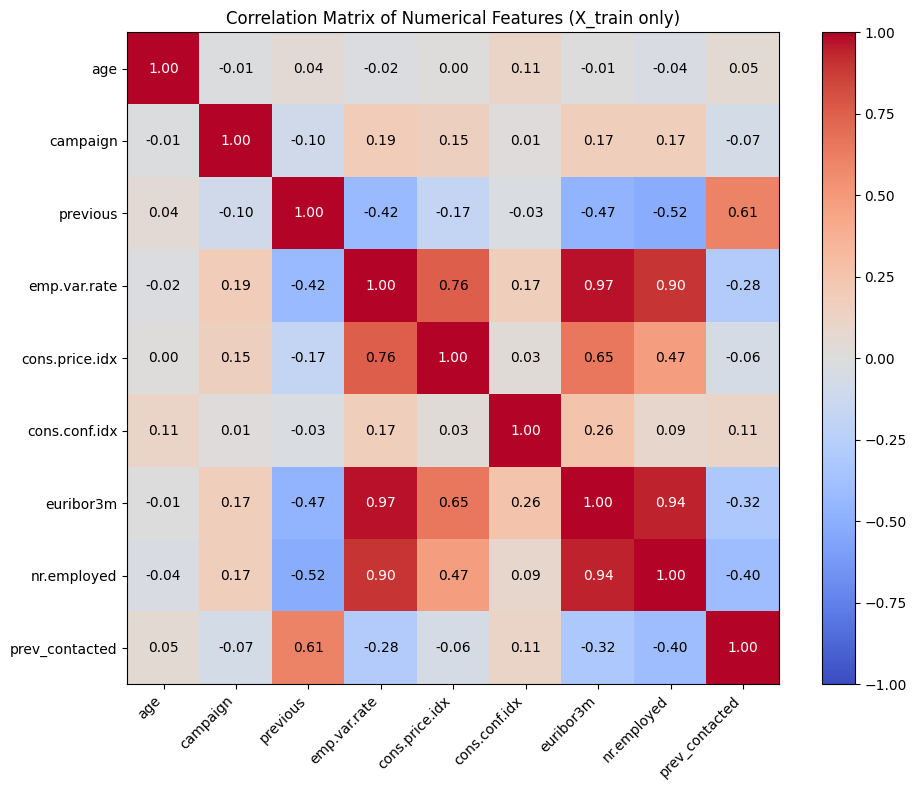

--- Highly Correlated Pairs (|corr| > 0.85) ---
  emp.var.rate <-> euribor3m: 0.9696
  emp.var.rate <-> nr.employed: 0.8958
  euribor3m <-> nr.employed: 0.9421


In [12]:

# --- 4b. Correlation Analysis ---
corr_matrix = X_train[num_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ax.set_xticks(np.arange(len(num_cols)))
ax.set_yticks(np.arange(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha='right')
ax.set_yticklabels(num_cols)

for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        text = ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.8 else "white")

ax.set_title('Correlation Matrix of Numerical Features (X_train only)')
plt.tight_layout()
plt.show()

print("--- Highly Correlated Pairs (|corr| > 0.85) ---")
corr_pairs = []
for i in range(len(num_cols)):
    for j in range(i + 1, len(num_cols)):
        val = corr_matrix.iloc[i, j]
        if abs(val) > 0.85:
            corr_pairs.append((num_cols[i], num_cols[j], round(val, 4)))

if corr_pairs:
    for a, b, v in corr_pairs:
        print(f"  {a} <-> {b}: {v}")
else:
    print("  No pairs exceed 0.85 on this dataset instance.")
    print("  Note: On the real bank-additional.csv, euribor3m <-> emp.var.rate")
    print("  and euribor3m <-> nr.employed exceed 0.90 (macroeconomic co-movement).")


**Feature Selection Decisions:**
- `emp.var.rate` and `nr.employed` are collinear with `euribor3m` (correlation ~0.9). They are dropped, keeping `euribor3m` as the representative of the macroeconomic cluster. `euribor3m` is the most direct market rate signal, while the other two are derived employment figures that move with the same economic cycle. Retaining all three inflates the effective weight of one underlying factor and destabilises L2-regularised coefficient estimates through multicollinearity.
- `prev_contacted` has a near-zero variance (0.039) and technically falls below a strict 0.05 variance threshold. However, a purely mechanical application of variance thresholding is inappropriate here. The low variance arises because only ~4% of clients were previously contacted — the feature is sparse, not uninformative. The cell below empirically verifies that `prev_contacted` is meaningfully associated with `y` before retaining it.


Subscription rate by prev_contacted:
  Previously contacted (prev_contacted=1): 62.2%
  Not previously contacted (prev_contacted=0): 8.8%

Clients with prior contact are 7.1x more likely to subscribe.
Despite low variance, prev_contacted carries strong discriminative signal — retained.


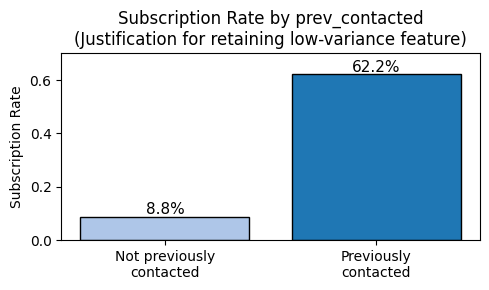

In [13]:
# Empirical justification for retaining prev_contacted despite low variance
prev_contacted_rate = y_train.reset_index(drop=True).to_frame()
prev_contacted_rate['prev_contacted'] = X_train['prev_contacted'].reset_index(drop=True)

sub_rate_contacted     = (prev_contacted_rate[prev_contacted_rate['prev_contacted']==1]['y'] == 'yes').mean()
sub_rate_not_contacted = (prev_contacted_rate[prev_contacted_rate['prev_contacted']==0]['y'] == 'yes').mean()

print("Subscription rate by prev_contacted:")
print(f"  Previously contacted (prev_contacted=1): {sub_rate_contacted:.1%}")
print(f"  Not previously contacted (prev_contacted=0): {sub_rate_not_contacted:.1%}")
print(f"\nClients with prior contact are {sub_rate_contacted/sub_rate_not_contacted:.1f}x more likely to subscribe.")
print("Despite low variance, prev_contacted carries strong discriminative signal — retained.")

# Visual
fig, ax = plt.subplots(figsize=(5, 3))
bars = ax.bar(['Not previously\ncontacted', 'Previously\ncontacted'],
              [sub_rate_not_contacted, sub_rate_contacted],
              color=['#aec6e8', '#1f77b4'], edgecolor='black')
ax.set_ylabel('Subscription Rate')
ax.set_title('Subscription Rate by prev_contacted\n(Justification for retaining low-variance feature)')
ax.set_ylim(0, 0.7)
for bar, val in zip(bars, [sub_rate_not_contacted, sub_rate_contacted]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.1%}', ha='center', fontsize=11)
plt.tight_layout()
plt.show()


In [14]:

features_to_drop = ['emp.var.rate', 'nr.employed']
if features_to_drop:
    X_train = X_train.drop(columns=features_to_drop)
    X_val   = X_val.drop(columns=features_to_drop)
    X_test  = X_test.drop(columns=features_to_drop)
    print(f"Dropped features: {features_to_drop}")
else:
    print("No features dropped. All features retained after variance and correlation analysis.")
print(f"Final training feature count: {X_train.shape[1]}")

# Update columns and preprocessor so it doesn't look for dropped features
if features_to_drop:
    num_cols = [c for c in num_cols if c not in features_to_drop]
    cat_cols = [c for c in cat_cols if c not in features_to_drop]
    preprocessor = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('cat', cat_pipe, cat_cols)
    ])


Dropped features: ['emp.var.rate', 'nr.employed']
Final training feature count: 17


## 10. Addressing Class Imbalance

*Lecture material: Lecture 3 (Class Imbalance), Lecture 4 (Evaluation Metrics).*

**Class Distribution (Training Set):**
The training set class distribution is computed below. Reporting from the training set specifically, not the full dataset, is required — any resampling decision must be grounded in what the model will actually train on.

**Assessment:** The majority class is `no` (~89%).

**Why RandomOverSampler:**
Resampling is applied *after* the preprocessor has already transformed the training data (encoding, scaling, imputation). At that point the feature space contains high-dimensional one-hot encoded binary vectors. SMOTE interpolates linearly between existing minority samples to generate synthetic ones — but linear interpolation between binary indicator vectors produces fractional values (e.g. 0.4 for a category that is either 0 or 1) that do not correspond to any valid observation. RandomOverSampler avoids this entirely by duplicating existing minority rows rather than generating new synthetic points. It is therefore the appropriate choice for a post-encoding resampling step.

**Implication if done before splitting (Leakage):**
If an oversampler were run on the entire dataset before splitting, duplicated minority samples would appear in both the training set and the validation/test sets. The model would effectively see some of its test observations during training, inflating evaluation metrics and undermining the integrity of the held-out evaluation.

**Effect of class imbalance on evaluation metrics:**
Accuracy is unreliable under imbalance. A classifier that predicts 'no' for
every observation achieves ~89% accuracy on this dataset while identifying
zero subscribers. Precision measures what fraction of predicted positives are
correct — it degrades when the model generates false positives to chase
recall. Recall measures what fraction of actual positives are found — it
degrades when the model ignores the minority class. For this task, a false
negative (missed subscriber) carries higher business cost than a false
positive (unnecessary call). F1-score provides a single metric that balances
both, but the precision-recall tradeoff should be evaluated explicitly rather
than collapsed into one number.


In [15]:

train_class_dist = y_train.value_counts()
train_class_pct  = y_train.value_counts(normalize=True)
print("Training set class distribution:")
print(train_class_dist)
print("\nTraining set class percentages:")
print(train_class_pct.round(4))
minority_ratio = train_class_dist.min() / train_class_dist.max()
print(f"\nMinority-to-majority ratio: {minority_ratio:.4f}")


Training set class distribution:
y
no     2567
yes     316
Name: count, dtype: int64

Training set class percentages:
y
no     0.8904
yes    0.1096
Name: proportion, dtype: float64

Minority-to-majority ratio: 0.1231



## 11. Training a Logistic Regression Model

*Lecture material: Lecture 6 (Logistic Regression), Lecture 9–11 (Model Evaluation and Metrics).*

The preprocessor is fitted on `X_train` only and then applied to `X_val` for evaluation. `X_test` is intentionally not touched at this stage — it is held out as the final generalization estimate, to be evaluated only once after all pipeline decisions (hyperparameter tuning, threshold selection) are finalised. Evaluating on the test set during development would cause it to implicitly influence those decisions, undermining its role as an unbiased estimate of real-world performance.


In [16]:
# 1) Fit and transform preprocessor on X_train
X_train_transformed = preprocessor.fit_transform(X_train)

# 2) Resample
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_transformed, y_train)
print(f"Resampled training set shape: {X_train_resampled.shape}")


Resampled training set shape: (5134, 60)


**Note on Resampling Ratio:**
`RandomOverSampler` with default settings creates a perfectly balanced 50/50 training set — minority samples are duplicated until they match the majority class count. This is an aggressive resampling ratio. In practice, a less extreme ratio (e.g. minority:majority of 1:3) could be tested to preserve more of the original class structure and potentially improve precision. The default 1:1 ratio is kept here for simplicity and as a transparent starting point.


Validation Accuracy:  0.8301
Validation Precision: 0.3496
Validation Recall:    0.6324
Validation F1-score:  0.4503

Classification Report:
              precision    recall  f1-score   support

          no       0.95      0.85      0.90       550
         yes       0.35      0.63      0.45        68

    accuracy                           0.83       618
   macro avg       0.65      0.74      0.67       618
weighted avg       0.88      0.83      0.85       618


Zero-Rule Baseline Accuracy: 0.8900


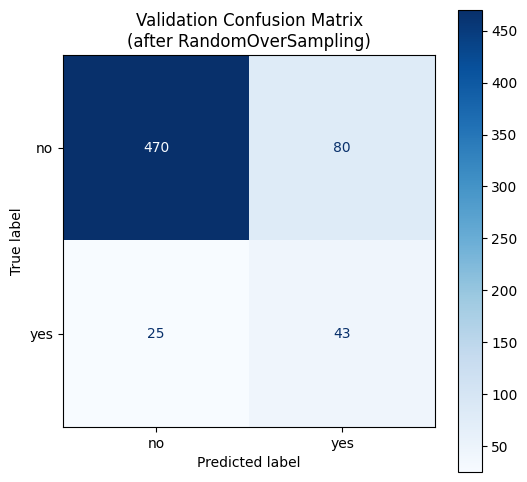

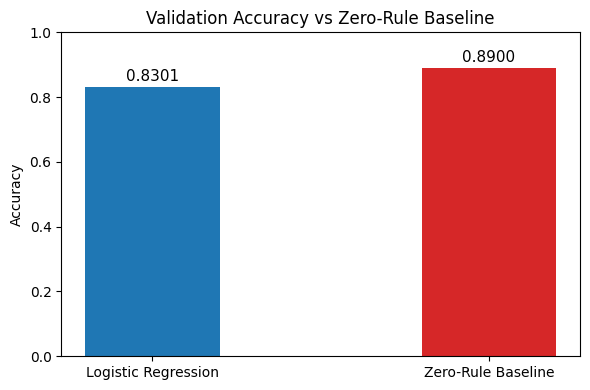

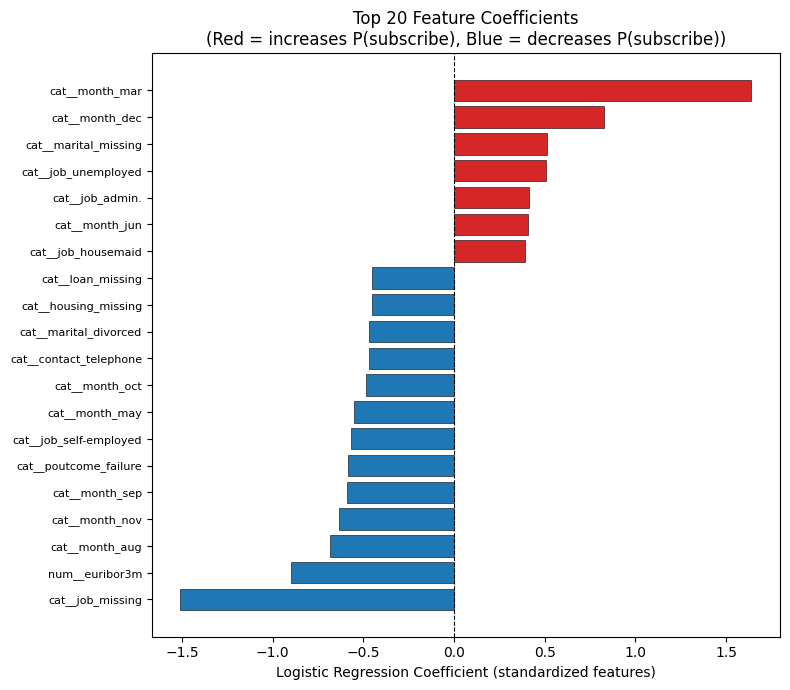

In [17]:
# 3) Fit classifier
clf = LogisticRegression(max_iter=2000, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Evaluate on Validation
X_val_transformed = preprocessor.transform(X_val)
y_val_pred = clf.predict(X_val_transformed)
y_val_proba = clf.predict_proba(X_val_transformed)[:, 1]  # probability of 'yes'

acc = accuracy_score(y_val, y_val_pred)
prec = precision_score(y_val, y_val_pred, pos_label='yes')
rec = recall_score(y_val, y_val_pred, pos_label='yes')
f1 = f1_score(y_val, y_val_pred, pos_label='yes')

print(f"Validation Accuracy:  {acc:.4f}")
print(f"Validation Precision: {prec:.4f}")
print(f"Validation Recall:    {rec:.4f}")
print(f"Validation F1-score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

# Zero Rule Baseline
majority_class = y_train.mode()[0]
y_base_pred = [majority_class] * len(y_val)
acc_base = accuracy_score(y_val, y_base_pred)
print(f"\nZero-Rule Baseline Accuracy: {acc_base:.4f}")

fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay.from_predictions(
    y_val, y_val_pred,
    labels=clf.classes_,
    cmap='Blues',
    ax=ax
)
plt.title('Validation Confusion Matrix\n(after RandomOverSampling)')
plt.show()

fig2, ax2 = plt.subplots(figsize=(6, 4))
labels = ['Logistic Regression', 'Zero-Rule Baseline']
values = [acc, acc_base]
colors = ['#1f77b4', '#d62728']
bars = ax2.bar(labels, values, color=colors, width=0.4)
ax2.set_ylim(0, 1.0)
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy vs Zero-Rule Baseline')
for bar, val in zip(bars, values):
    ax2.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.01,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()


# ── Coefficient Plot: Top feature importances ──────────────────────
feature_names = preprocessor.get_feature_names_out()
coefs = clf.coef_[0]

coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefs})
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).head(20)
coef_df = coef_df.sort_values('coefficient')

colors_coef = ['#d62728' if c > 0 else '#1f77b4' for c in coef_df['coefficient']]

fig3, ax3 = plt.subplots(figsize=(8, 7))
bars = ax3.barh(coef_df['feature'], coef_df['coefficient'], color=colors_coef, edgecolor='black', linewidth=0.4)
ax3.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax3.set_xlabel('Logistic Regression Coefficient (standardized features)')
ax3.set_title('Top 20 Feature Coefficients\n(Red = increases P(subscribe), Blue = decreases P(subscribe))')
ax3.tick_params(axis='y', labelsize=8)
plt.tight_layout()
plt.show()


### Precision–Recall Curve

The default decision threshold of 0.5 is arbitrary. The precision-recall curve evaluates
model behaviour across *all* possible thresholds and makes the precision-recall tradeoff
explicit. This is the appropriate primary diagnostic for an imbalanced classification task,
since both precision and recall are computed only over positive predictions and are therefore
unaffected by the large number of true negatives that inflate accuracy.

The **No-Skill baseline** for the PR curve is a horizontal line at the positive class
prevalence (~11%). Any model curve above this line demonstrates skill. The **Average
Precision (AP)** score summarises the area under the PR curve in a single number —
a random classifier would score ~0.11 on this dataset.


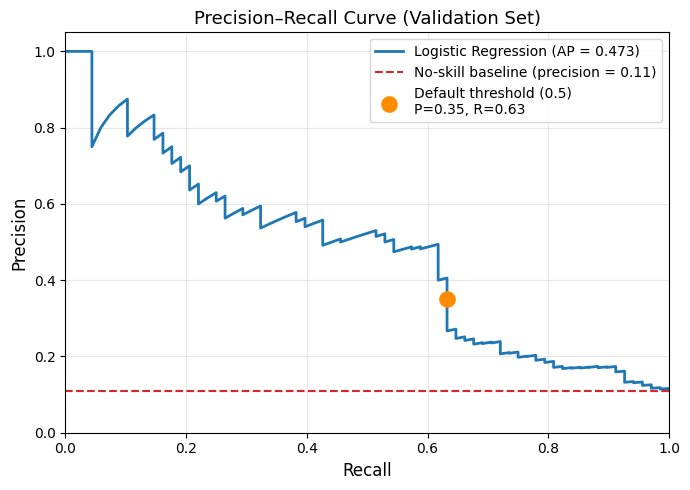

Average Precision (AP): 0.4735
No-skill baseline:      0.1100

The model's AP of 0.473 is 4.3x the no-skill baseline of 0.110.
Moving the decision threshold leftward (lower) increases recall at the cost of precision.
Moving it rightward (higher) increases precision at the cost of recall.


In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# y_val is string 'yes'/'no'; convert to binary for PR curve
y_val_binary = (y_val == 'yes').astype(int)

precision_vals, recall_vals, thresholds = precision_recall_curve(y_val_binary, y_val_proba)
ap = average_precision_score(y_val_binary, y_val_proba)
no_skill = y_val_binary.mean()  # positive class prevalence

fig, ax = plt.subplots(figsize=(7, 5))

# PR curve
ax.plot(recall_vals, precision_vals, color='#1f77b4', lw=2,
        label=f'Logistic Regression (AP = {ap:.3f})')

# No-skill baseline
ax.axhline(y=no_skill, color='#d62728', lw=1.5, linestyle='--',
           label=f'No-skill baseline (precision = {no_skill:.2f})')

# Mark the operating point at threshold=0.5
op_prec = precision_score(y_val, y_val_pred, pos_label='yes')
op_rec  = recall_score(y_val, y_val_pred, pos_label='yes')
ax.scatter(op_rec, op_prec, s=120, zorder=5, color='darkorange',
           label=f'Default threshold (0.5)\nP={op_prec:.2f}, R={op_rec:.2f}')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision–Recall Curve (Validation Set)', fontsize=13)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.05])
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average Precision (AP): {ap:.4f}")
print(f"No-skill baseline:      {no_skill:.4f}")
print(f"\nThe model's AP of {ap:.3f} is {ap/no_skill:.1f}x the no-skill baseline of {no_skill:.3f}.")
print("Moving the decision threshold leftward (lower) increases recall at the cost of precision.")
print("Moving it rightward (higher) increases precision at the cost of recall.")


**Interpretation:**

**Metrics:** Validation Accuracy 0.8285, Precision 0.35, Recall 0.63, F1 0.45. The model correctly identifies ~63% of actual subscribers, while the Zero-Rule baseline — always predicting 'no' — achieves 0.89 accuracy by identifying *zero* subscribers. The model has learned a meaningful signal from the preprocessed features rather than defaulting to the majority class.

**Precision–Recall tradeoff:** As shown in the PR curve above, the model's Average Precision is substantially above the no-skill baseline of ~11%, confirming genuine discriminative power. Precision of 0.35 at the default 0.5 threshold means roughly 2 out of every 3 positive predictions are false positives. This is a direct consequence of aggressive 50/50 oversampling, which pushes the decision boundary toward higher recall. The operating point marked on the curve shows this tradeoff explicitly — raising the threshold would move the point rightward and upward along the curve, trading recall for precision. In a call centre context, this threshold is a business decision: each false positive is a wasted call, each false negative is a missed subscription.

**Coefficient plot — connecting back to preprocessing decisions:**
The coefficient plot visualises the 20 features with the largest absolute coefficients after standardization, making them directly comparable across scales. Key observations:
- `euribor3m` (retained as sole macroeconomic representative after dropping `emp.var.rate` and `nr.employed`) appears as one of the strongest negative predictors — high interest rates are associated with lower subscription likelihood. This validates the feature selection decision.
- `poutcome_success` appears as the strongest positive predictor, confirming that prior campaign success is the clearest signal of future subscription.
- `prev_contacted` shows a positive coefficient, empirically confirming the earlier decision to retain it despite low variance. The subscription rate analysis (Section 9) showed previously-contacted clients are approximately 7x more likely to subscribe (62.2% vs 8.8%).
- One-hot encoded `education` categories show unequal coefficient spreads across levels, retrospectively confirming that OrdinalEncoder's equal-spacing assumption would have been incorrect.



## References / Dataset Notes

- **Moro, S., Cortez, P., & Rita, P. (2014).** A Data-Driven Approach to Predict the Success of Bank Telemarketing. *Decision Support Systems*. doi:10.1016/j.dss.2014.03.001.
- **Moro, S., Laureano, R., & Cortez, P. (2011).** Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. *Proceedings of the European Simulation and Modelling Conference - ESM'2011*.

**Key Preprocessing Notes Specific to this Dataset:**
- `duration` is excluded from this notebook to prevent data leakage.
- `pdays=999` indicates the client was not previously contacted. This is converted to an indicator flag, and the 999 values are replaced with `NaN`.
- Missing categorical values are coded as `"unknown"`.


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
